# Imports

In [17]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
from sklearn.metrics import cohen_kappa_score
import torch
from tqdm import tqdm
import re
import gc
import csv
import matplotlib.pyplot as plt

# Prometheus LLM-as-a-Judge

## Load Datasets

In [24]:
num_samples = 21  # Number of samples to process
# === 1. Load data ===
df_base = pd.read_csv("inputs/dataset_human_eval.csv").head(num_samples) 
df_mistral = pd.read_csv("outputs/dataset_with_mistral_translations.csv").head(num_samples)
df_mt5 = pd.read_csv("outputs/dataset_with_mT5_translations.csv").head(num_samples)
df_tinyllama = pd.read_csv("outputs/dataset_with_tinyllama_translations.csv").head(num_samples)
df_nllb = pd.read_csv("outputs/dataset_with_NLLB_translations.csv").head(num_samples)
df_base["mistral"] = df_mistral["generated_translation"]
df_base["mistralHS"] = df_mistral["score_human"]

df_base["mt5"] = df_mt5["generated_translation"]
df_base["mt5HS"] = df_mt5["score_human"]

df_base["tinyllama"] = df_tinyllama["generated_translation"]
df_base["tinyllamaHS"] = df_tinyllama["score_human"]

df_base["nllb"] = df_nllb["generated_translation"]
df_base["nllbHS"] = df_nllb["score_human"]

## Load Model

In [5]:
# === 2. Load Prometheus Model ===
model_name = "prometheus-eval/prometheus-7b-v2.0"
#model_name = "Unbabel/M-Prometheus-3B"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    device_map="auto",
    torch_dtype=torch.float16,
    offload_folder="offload_prometheus",
    offload_buffers=True
)
model.eval()

Loading checkpoint shards: 100%|██████████| 8/8 [00:10<00:00,  1.29s/it]
Some parameters are on the meta device because they were offloaded to the cpu.


MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): MistralRMSNorm((4096,), eps=1e-0

## Prompt

In [6]:

# === 3. Rubric & prompt ===

rubric_data = {
    "criteria": "Semantic fidelity of the translation",
    "score1": "Completely wrong, the meaning is unrecognizable.",
    "score2": "Severe meaning errors or omissions or explanations.",
    "score3": "Some inaccuracies, but the general meaning is conveyed.",
    "score4": "Good fidelity, minor non-substantial differences.",
    "score5": "Perfectly faithful to the original meaning."
}

def build_judge_prompt(original, human_translation, model_translation):
    return f"""
You are a translation evaluator. Your task is to assign a score from 1 to 5 that reflects how well the model's translation preserves the original meaning.

Original:
{original}

Human:
{human_translation}

Model:
{model_translation}

### Score Rubrics:
{rubric_data["criteria"]}
Score 1: {rubric_data["score1"]}
Score 2: {rubric_data["score2"]}
Score 3: {rubric_data["score3"]}
Score 4: {rubric_data["score4"]}
Score 5: {rubric_data["score5"]}

Assess the semantic fidelity objectively. Assign the appropriate score based on the rubric.

Score (1–5):
""".strip()

def extract_score(output):
    match = re.search(r"Score\s*\(1[\-–]5\):\s*(\d)", output)
    return int(match.group(1)) if match else None


## Run Prometheus

In [25]:
# === 4. Score ===
score_as = []
score_bs = []
score_cs = []
score_ds = []
winners = []

for _, row in tqdm(df_base.iterrows(), total=len(df_base)):
    for label, translation, score_list in [("A", row["mistral"], score_as), ("B", row["nllb"], score_bs),("C", row["tinyllama"], score_cs),("D", row["mt5"], score_ds)]:
        prompt = build_judge_prompt(row["Sentence"], row["HumanEval"], translation)
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to(model.device)
        with torch.no_grad():
            output_ids = model.generate(**inputs, max_new_tokens=2, do_sample=False)
        output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        score = extract_score(output_text)
        score_list.append(score)

        # Clear memory
        del inputs, output_ids
        torch.cuda.empty_cache()
        gc.collect()

    score_a = score_as[-1]
    score_b = score_bs[-1]
    score_c = score_cs[-1]
    score_d = score_ds[-1]
    if score_a is None or score_b is None:
        winners.append("?")
    elif score_a > score_b and score_a > score_c and score_a > score_d:
        winners.append("Mistral")
    elif score_b > score_a and score_b > score_c and score_b > score_d:
        winners.append("Nllb")
    elif score_c > score_a and score_c > score_b and score_c > score_d:
        winners.append("TinyLlama")
    elif score_d > score_a and score_d > score_b and score_d > score_c:
        winners.append("Mt5") 
    else:
        winners.append("=")

# === 5. Save ===
df_base["score_a"] = score_as
df_base["score_b"] = score_bs
df_base["score_c"] = score_cs
df_base["score_d"] = score_ds
df_base["winner"] = winners

df_base.to_csv("outputs/prometheus_eval.csv", index=False, quoting=csv.QUOTE_MINIMAL)
print("File saved in outputs/prometheus_eval.csv")


df_mistral = df_base[["Sentence", "HumanEval", "mistral", "score_a", "winner"]].rename(columns={"mistral": "translation", "score_a": "score"})
df_nllb    = df_base[["Sentence", "HumanEval", "nllb", "score_b", "winner"]].rename(columns={"nnlb": "translation", "score_b": "score"})
df_tiny    = df_base[["Sentence", "HumanEval", "tinyllama", "score_c", "winner"]].rename(columns={"tinyllama": "translation", "score_c": "score"})
df_mt5     = df_base[["Sentence", "HumanEval", "mt5", "score_d", "winner"]].rename(columns={"mt5": "translation", "score_d": "score"})

# Save the DataFrames as JSONL files
df_mistral.to_json("outputs/salmonators-hw2_transl-judge_mistral.jsonl", orient="records", lines=True, force_ascii=False)
df_nllb.to_json("outputs/salmonators-hw2_transl-judge_nllb.jsonl", orient="records", lines=True, force_ascii=False)
df_tiny.to_json("outputs/salmonators-hw2_transl-judge_tinyllama.jsonl", orient="records", lines=True, force_ascii=False)
df_mt5.to_json("outputs/salmonators-hw2_transl-judge_mt5.jsonl", orient="records", lines=True, force_ascii=False)

print("Files saved in outputs/:")
print("- prometheus_eval.csv (completo)")
print("- outputs/salmonators-hw2_transl-judge_mistral.jsonl")
print("- salmonators-hw2_transl-judge_nllb.jsonl")
print("- salmonators-hw2_transl-judge_tinyllama.jsonl")
print("- salmonators-hw2_transl-judge_mt5.jsonl")


  0%|          | 0/20 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
  5%|▌         | 1/20 [00:05<01:51,  5.87s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
 10%|█         | 2/20 [00:11<01:39,  5.53s/it]Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
 15%|█▌        | 3/20 [00:16<01:34,  5.53s/it]Setting 

File saved in outputs/prometheus_eval.csv
Files saved in outputs/:
- prometheus_eval.csv (completo)
- outputs/salmonators-hw2_transl-judge_mistral.jsonl
- salmonators-hw2_transl-judge_nllb.jsonl
- salmonators-hw2_transl-judge_tinyllama.jsonl
- salmonators-hw2_transl-judge_mt5.jsonl


# Correlation

In [26]:
def evaluate_concordance(y_true, y_pred):
    print("== Unique values ==")
    print("Human:", sorted(set(y_true)))
    print("Model:", sorted(set(y_pred)))
    
    if len(set(y_true)) < 2 or len(set(y_pred)) < 2:
        print("Not enough variability to be able to calculate Cohen's Kappa.")
        return
    
    print("\n== Cohen’s Kappa ==")
    print(f"{cohen_kappa_score(y_true, y_pred):.3f}")
    return cohen_kappa_score(y_true, y_pred)


In [27]:
df_base = pd.read_csv("outputs/prometheus_eval.csv")
print("\n MISTRAL")
ck_a=evaluate_concordance(df_base["mistralHS"], df_base["score_a"])
print("\n NLLB")
ck_b=evaluate_concordance(df_base["nllbHS"], df_base["score_b"])
print("\n TinyLlama")
ck_c=evaluate_concordance(df_base["tinyllamaHS"], df_base["score_c"])
print("\n Mt5")
ck_d=evaluate_concordance(df_base["mt5HS"], df_base["score_d"])



 MISTRAL
== Unique values ==
Human: [3, 4, 5]
Model: [3, 5]

== Cohen’s Kappa ==
0.565

 NLLB
== Unique values ==
Human: [2, 3, 4, 5]
Model: [1, 3, 5]

== Cohen’s Kappa ==
0.508

 TinyLlama
== Unique values ==
Human: [1, 2, 3, 4, 5]
Model: [1, 2, 3, 5]

== Cohen’s Kappa ==
0.219

 Mt5
== Unique values ==
Human: [2, 3, 4, 5]
Model: [1, 3, 5]

== Cohen’s Kappa ==
0.128


(0.0, 1.0)

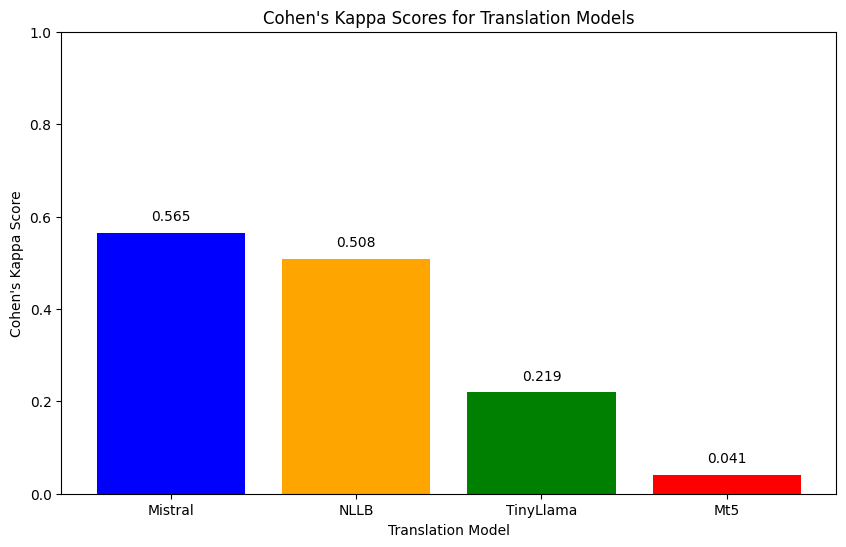

In [12]:
# Plot the results of cohen kappa scores
scores = [ck_a, ck_b, ck_c, ck_d]
labels = ['Mistral', 'NLLB', 'TinyLlama', 'Mt5']
plt.figure(figsize=(10, 6))
plt.title("Cohen's Kappa Scores for Translation Models")
plt.xlabel("Translation Model")
plt.ylabel("Cohen's Kappa Score")
bars=plt.bar(labels, scores, color=['blue', 'orange', 'green', 'red'])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.3f}', ha='center', va='bottom')
plt.ylim(0, 1)